# **Text Classification with an RNN and a Transformer**

---

## **Introduction**

In this notebook, I will be using the tripadvisor hotel reviews dataset to build a text classification model. The dataset contains 20,000 reviews and their corresponding ratings. It can be found [here](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews). I will be comparing the performance of a Recurrent Neural Network (RNN) and a Transformer model.

**The goal of the notebook will be to predict the rating of a review based on the text content.**

## **Table of Contents**

1. [Importing Libraries and Dataset](#1.-Importing-Libraries-and-Dataset)
2. [Data Preprocessing](#2.-Data-Preprocessing)  
    2.1 [Tokenization & Padding](#2.1-Tokenization-&-Padding)  
    2.2 [Train-Test Split](#2.2-Train-Test-Split)  
3. [Recurrent Neural Network (RNN)](#3.-Recurrent-Neural-Network-(RNN))   
    3.1 [ROC Curve](#3.1-ROC-Curve)
4. [Transformer Model](#4.-Transformer-Model)  

## **1. Importing Libraries and Dataset**

---

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

df = pd.read_csv('./data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## **2. Data Preprocessing**

[Back to Top](#Table-of-Contents)

---

Since the dataset is already clean, I will only be performing the following preprocessing steps:

1. Tokenization & Padding
3. Train-Test Split

#### **2.1 Tokenization & Padding**

> Tokenization is the process of converting text into tokens. A token is a sequence of characters in a specific format.

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])

sequences = tokenizer.texts_to_sequences(df['Review'])
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

To tokenize the text data, I've used the Tokenizer class from the keras.preprocessing.text module. Then, I've used the texts_to_sequences method to convert the text data into sequences of integers. Finally, I've used the pad_sequences method to pad the sequences to a fixed length of 200. Padding is the process of adding zeros to the sequences to make them all the same length.

#### **2.2 Train-Test Split**

In [16]:
labels = df['Rating'].values - 1

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

For the labels I've used the `Rating` (1-5) and removed 1 from them so that they become 0-4, because the ratings will be used as labels for the classification model. Then, I've split the data into training and testing sets using the train_test_split method from the sklearn.model_selection module.

## **3. Recurrent Neural Network (RNN)**

[Back to Top](#Table-of-Contents)

---

For the RNN model I will be using an Embedding layer followed by two Bidirectional LSTM layers. The Embedding layer is used to convert the integer sequences into dense vectors of fixed size. A Bidirectional LSTM layer is a type of Recurrent Neural Network (RNN) that processes the input sequence in both forward and backward directions. This allows the model to capture long-range dependencies in the input sequence. Meaning that the model can learn from the entire sequence, not just the previous words.

 The Dropout layers are used to prevent overfitting by randomly setting a fraction of the input units to zero. The Dense layers are used to map the output of the LSTM layers to the number of classes (5 in this case).

In [17]:
model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 64),
    Bidirectional(LSTM(64, return_sequences=True)), 
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/3
257/257 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step - accuracy: 0.4530 - loss: 1.2909 - val_accuracy: 0.5775 - val_loss: 0.9363
Epoch 2/3
257/257 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.6032 - loss: 0.8765 - val_accuracy: 0.6243 - val_loss: 0.8648
Epoch 3/3
257/257 ━━━━━━━━━━━━━━━━━━━━ 38s 148ms/step - accuracy: 0.7031 - loss: 0.6872 - val_accuracy: 0.6199 - val_loss: 0.9203


In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6108 - loss: 0.9264
Test Accuracy: 0.6199


The RNN model achieved an accuracy of 60.58% on the test set, which is quite good considering the simplicity of the model. And actually, looking online, it seems that this is a pretty good result for this dataset, with most models achieving around 60-70% accuracy.

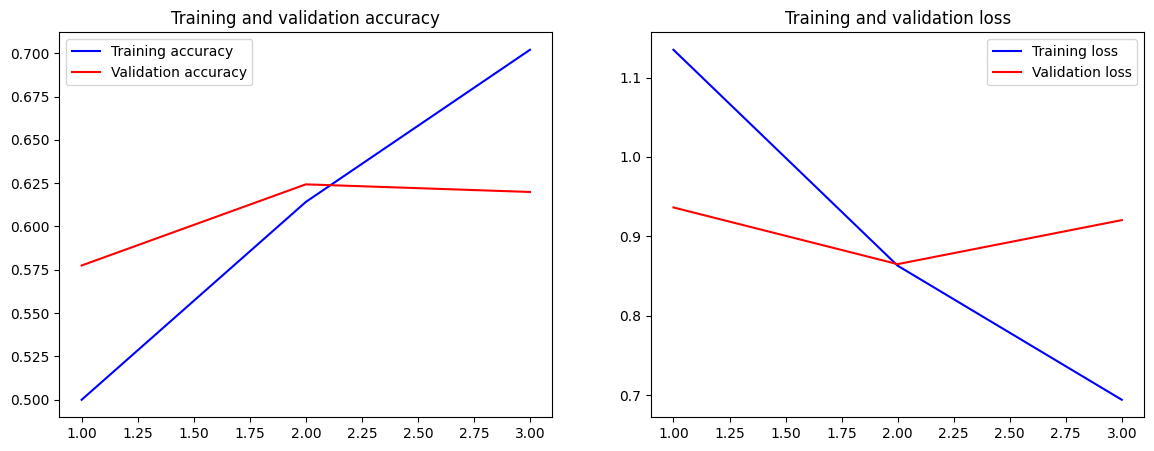

In [19]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

plot_history(history)

Looking at the above plots, we can see that the model is overfitting. To combat this, I've already added Dropout layers to the model. However, for future work, one could try adding more Dropout layers, reducing the number of LSTM units, or using a simpler model architecture.

#### **3.1 ROC Curve**

> The ROC curve is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity). It shows the trade-off between sensitivity and specificity for different threshold values.

129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


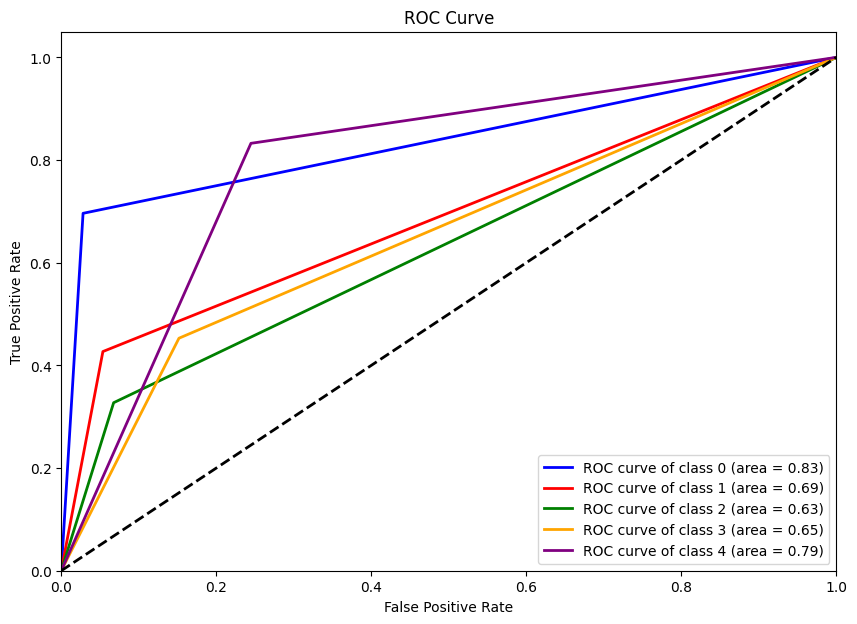

In [20]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3, 4])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10, 7))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

From the ROC curve, we observe that the model performs best for class 0 with an AUC of 0.83, indicating high accuracy in identifying ratings of 1 star. Then, Class 4 follows with an AUC of 0.79. This means that the model is best able to distinguist between both 5, and 1 star ratings. However, the model struggles with classes 1, 2 and 3, which have lower AUCs. This suggests the model has difficulty distinguishing these classes. 

This actually makes quite a lot of sense, as ratings of 1 and 5 are likely to be more extreme and therefore easier to classify. Ratings of 2, 3 and 4 are more similar and therefore harder to distinguish.

> Area Under the Curve (AUC) is a metric that measures the performance of a classification model. It is the area under the ROC curve, which is a plot of the true positive rate against the false positive rate for different threshold values. (e.g AUC of 0.5 is random, 1 is perfect)

## **4. Transformer Model**

[Back to Top](#Table-of-Contents)

---

As for the Transformer model, I will be using the BERT (Bidirectional Encoder Representations from Transformers) model. BERT is a pre-trained Transformer model that has been trained on a large corpus of text data.

The reason for not fine-tuning the BERT model (I tried) is that it is computationally expensive. Instead, I will be using a fine-tuned version of the BERT model, `nlptown/bert-base-multilingual-uncased-sentiment`, which has been fine-tuned product reviews in multiple languages.

In [21]:
nlp = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

def compare_models(review):
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=200, padding='post', truncating='post')
    lstm_prediction = model.predict(padded_sequence)
    bert_prediction = nlp(review)
    print(f'Review: {review}')
    print(f'LSTM Prediction: {lstm_prediction}')
    print(f'BERT Prediction: {bert_prediction}')
    print(f'LSTM Score: {np.argmax(lstm_prediction) + 1}')
    bert_score = int(bert_prediction[0]["label"].split(' ')[0])
    print(f'BERT Score: {bert_score}')
    print(f'Correct Score: {df[df["Review"] == review]["Rating"].values[0]}')
    print()
    
for i in range(5):
    compare_models(df['Review'][i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Review: nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  
LSTM Prediction: [[0.0122606  0.12158183 0.5063237  0.33972475 0.0201091 ]]
BERT Prediction: [{'label': '4 stars', 'score': 0.5907365679740906}]
LSTM Score: 3
BERT Score: 4
Correct Score: 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Review: ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra 

When comparing the predictions of the LSTM and BERT, we can see that funny enough, the LSTM model seems to be performing better in some cases. For example, in the last review, the LSTM model predicted a score of 5, while the BERT model predicted a score of 1. This could be due to the fact that the BERT model has been fine-tuned on product reviews, while the LSTM model has been trained on the tripadvisor hotel reviews dataset. 